In [1]:
import json
import numpy as np
import cv2

In [2]:
import os
import sys

from ipynb.fs.full.quantumsystem import QuantumSystem, qs, System, HyperSystem, IntegerSystem, FloatSystem, FloatArraySystem

In [3]:
MM_TO_INCHES =  0.03937008

In [4]:
class XYLocation(FloatArraySystem):
    """ Location in XY plane """
    @classmethod
    def validate(cls, terminant):
        if len(terminant) != 2:
            raise Exception(f"Unrecognized terminant: {terminant}")
        return super().validate(terminant)
    
    @classmethod
    def origin(cls):
        return (0, 0)

In [5]:
class Elevation(IntegerSystem):
    """ Elevation from XY plane """

In [6]:
class DistanceMoved(FloatSystem):
    """ Distance Moved """

    @classmethod
    def get_relationship(cls, entity):
        rel = super().get_relationship(entity)
        return rel if rel is not None else 0

In [7]:
class MovementSpeed(FloatSystem):
    """ Movement Speed Value """

    class MovementSpeedViolation(Exception):
        """ An exception for moving beyond the MovementSpeed distance """

class JumpJets(System):
    """ Jump Jets """
    
    @classmethod
    def has_jump_jets(cls, entity):
        return cls.get_relationship(entity) == 'j'
    
    @classmethod
    def validate(cls, terminant):
        if terminant not in ['null', 'j']:
            raise Exception(f"Invalid JumpJets terminant: {terminant}")
        return terminant

In [8]:
class Footprint(System):
    """ 2D Footprint of an Object as an cv2 Contour"""
    example_footprint = np.array([
    [10, 10], [12, 12], [15, 15], [20, 15], [25, 14],
    [30, 10], [28, 8], [25, 5], [20, 5], [15, 6], [12, 8]
], dtype=np.int32).reshape((-1, 1, 2))
    
    @classmethod
    def get_relationship(cls, entity):
        rel = super().get_relationship(entity)
        if rel is not None:
            return np.array(json.loads(rel), dtype=np.int32)
        return None

    @classmethod
    def validate(cls, terminant):
        return json.dumps([(int(pnt[0]), int(pnt[1])) for contour in terminant for pnt in contour])

    @classmethod
    def intersection(cls, entityA, entityB):
        footprintA = cls.get_relationship(entityA)
        footprintB = cls.get_relationship(entityB)

        terminantAArea = cv2.contourArea(footprintA)
        
        zeros = np.zeros([1200, 1200, 1], dtype=np.uint8)
        changeIm = cv2.drawContours(zeros.copy(), [footprintA], -1, 255, -1)
        otherIm = cv2.drawContours(zeros.copy(), [footprintB], -1, 255, -1)
        overlap = cv2.bitwise_and(changeIm, otherIm)
        if overlap.any():
            contours = cv2.findContours(overlap, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
            largestArea = max([cv2.contourArea(c) for c in contours])
            overlapRatio = largestArea / terminantAArea
            if 0.1 < overlapRatio < 2.0:
                return True
            else:
                print(f"Overlap ratio is too low: {overlapRatio}")
        return False

    @classmethod
    def point_intersection(cls, entity: str, location: tuple[int, int]):
        footprint = cls.get_relationship(entity)
        
        zeros = np.zeros([1200, 1200, 1], dtype=np.uint8)
        changeIm = cv2.drawContours(zeros.copy(), [footprint], -1, 255, -1)
        otherIm = cv2.circle(zeros.copy(), location, 2, 255, -1)
        overlap = cv2.bitwise_and(changeIm, otherIm)
        return overlap.any()

In [9]:
@Elevation.sd
@DistanceMoved.sd
@JumpJets.sd
@MovementSpeed.sd
@Footprint.sd
@XYLocation.sd
class Movement(HyperSystem):
    @classmethod
    def has_jump_jets(cls, entity):
        return JumpJets.has_jump_jets(entity)
    
    @classmethod
    def get_movement_speed(cls, entity):
        return float(MovementSpeed.get_relationship(entity))
    
    @classmethod
    def movement_cost(cls, delta: list[float, float, float], difficulty: int = 1, jump_jets: bool = False) -> float:
        """ Accepts movement delta in millimeters and terrain difficulty; returns movement_cost in inches """
        if jump_jets:
            totalCost = (sum([d * d for d in delta[:3]]) ** 0.5) * MM_TO_INCHES
            # print(f"====== Has jumpjets -- simple distance calculation: {totalCost}")
        else:
            horizontalDistance = sum([d * d for d in delta[:2]]) ** 0.5
            totalCost = (horizontalDistance * difficulty + delta[2] * 2) * MM_TO_INCHES
            # print(f"====== No jumpjets -- penalized distance calculation: {totalCost}")
        return totalCost

    @classmethod
    @Elevation.d
    @XYLocation.d
    @MovementSpeed.d
    def can_move(cls, entity: str, delta: list[float, float, float], movementspeed, xylocation, elevation):
        movement_cost = cls.movement_cost(delta)
        return cls.movement_cost(delta) <= movementspeed

    @classmethod
    @Elevation.d
    @XYLocation.d
    @MovementSpeed.d
    def move(cls, entity: str, delta: list[float, float, float], movementspeed, xylocation, elevation):
        xyz = [*xylocation, elevation]
        movement_cost = cls.movement_cost(delta)
        print(f"Movement cost: {movement_cost}")
        if movement_cost > movementspeed:
            raise MovementSpeed.MovementSpeedViolation(f"Cannot move unit further ({movement_cost:4.2f}) than its movement speed ({movementspeed:4.2f})")

        newLocation = [sL + lD for sL, lD in zip(xyz, delta)]
        xy = newLocation[:2]
        z = newLocation[2]
        DistanceMoved.set_relationship(entity, movement_cost)
        XYLocation.set_relationship(entity, xy)
        Elevation.set_relationship(entity, z)

    @classmethod
    @Elevation.d
    @XYLocation.d
    @MovementSpeed.d
    def move_to(cls, entity, newLocation, movementspeed, xylocation, elevation):
        xyz = [*xylocation, elevation]
        delta = [newD - oldD for newD, oldD in zip(newLocation, xyz)]
        cls.move(entity=entity, delta=delta, movementspeed=movementspeed, xylocation=xylocation, elevation=elevation)

Initial State


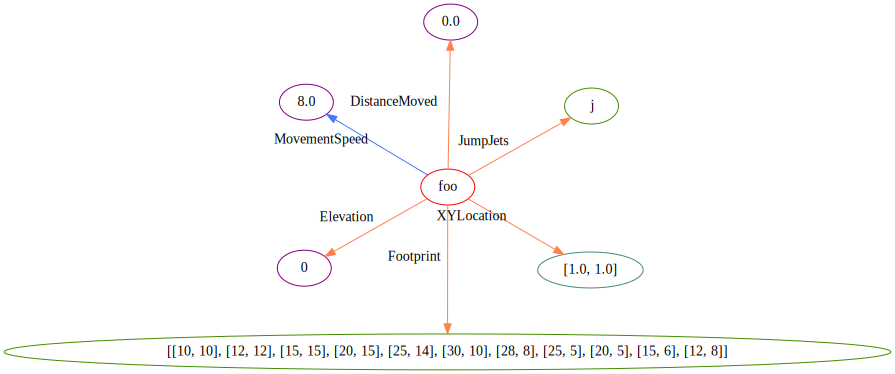

Movement cost: 0.27559056000000004
Movement cost: 35.433072
Caught expected Movement Speed Violation: Cannot move unit further (35.43) than its movement speed (8.00)
Movement cost: 0.05567770108771375
Final State


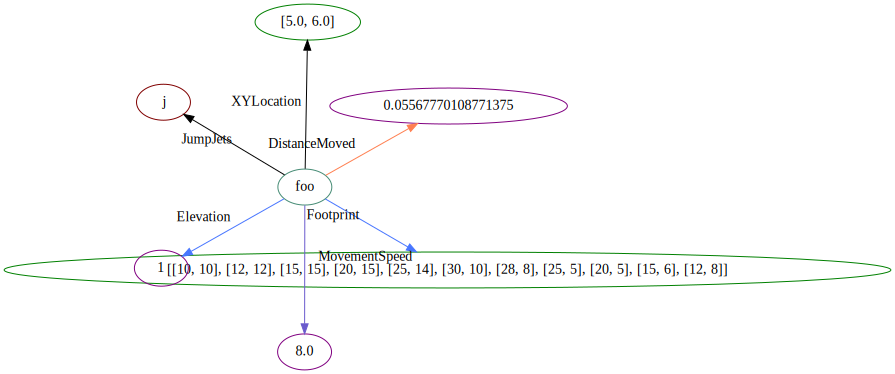

In [10]:
if __name__ == "__main__":
    from IPython.display import display
    qs.reset()
    Movement("foo", XYLocation=[1, 1], Elevation=0, MovementSpeed=8, JumpJets="j", DistanceMoved=0, Footprint=Footprint.example_footprint)
    assert Movement.has_jump_jets(entity="foo")
    assert Movement.entities() == ['foo']
    assert Footprint.intersection("foo", "foo")
    assert Footprint.point_intersection("foo", [15, 10])
    print("Initial State")
    display(qs.render())
    
    Movement.move(entity="foo", delta=[3, 4, 1])
    assert XYLocation.get_relationship("foo") == [4, 5]
    assert Elevation.get_relationship("foo") == 1
    assert DistanceMoved.get_relationship("foo") == (sum([d * d for d in [3, 4]]) ** 0.5 + 1 * 2) * MM_TO_INCHES
    
    try:
        Movement.move(entity="foo", delta=[900, 0, 0])
        raise Exception(f"Failed to catch movement speed violation")
    except MovementSpeed.MovementSpeedViolation as msv:
        print(f"Caught expected Movement Speed Violation: {msv}")
    
    Movement.move_to(entity="foo", newLocation=[5, 6, 1])
    assert XYLocation.get_relationship("foo") == [5, 6]
    assert Elevation.get_relationship("foo") == 1
    assert DistanceMoved.get_relationship("foo") == (sum([d * d for d in [1, 1]]) ** 0.5) * MM_TO_INCHES

    print("Final State")
    display(qs.render())